In [1]:
# Import all libraries needed for the tutorial
import pandas as pd 
import numpy as np
import os
import math
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from pandas import DataFrame, read_csv

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

from PIL import Image # to read images

import cv2
import scipy.io

In [2]:
#Prolly use sparse_categorical_crossentropy
#| Convolution + relu | pooling | Convolution + relu | pooling | flatten | BOOM
#Testa med IMG_SIZE = 64 och med 128

if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
print(tf.__version__)

##Cnn
#adam = Adam()

1 Physical GPUs, 1 Logical GPUs
2.4.1


In [3]:
DATADIR = "D:/car_devkit/"
CATEGORIES = ["croped_train"]
TEST_CATEGORIES = ["croped_test"]
IMG_SIZE = 64
IMG_SIZE_X = IMG_SIZE*2

## Load all the training images

In [4]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path_training = os.path.join(DATADIR, category)
        for img in os.listdir(path_training):
            try:
                img_array_training = cv2.imread(os.path.join(path_training,img), cv2.IMREAD_GRAYSCALE)
                new_array_training = cv2.resize(img_array_training, (IMG_SIZE_X, IMG_SIZE))
                training_data.append([new_array_training, img])
            except Exception as e:
                pass

create_training_data()

## Load all the test images

In [5]:
test_data = []

def create_test_data():
    for category in TEST_CATEGORIES:
        path_test = os.path.join(DATADIR, category)
        for img in os.listdir(path_test):
            try:
                img_array_test = cv2.imread(os.path.join(path_test, img), cv2.IMREAD_GRAYSCALE)
                new_array_test = cv2.resize(img_array_test, (IMG_SIZE_X, IMG_SIZE))
                test_data.append([new_array_test, img])
            except Exception as e:
                pass

create_test_data()

## Define all the functions needed

In [6]:
X_Train = []

def prepare_X_Train():
    for i in range(len(training_data)):
        X_Train.append(training_data[i][0])


In [7]:
X_Test = []

def prepare_X_Test():
    for i in range(len(test_data)):
        X_Test.append(test_data[i][0])


## Loads the diffenrent car models into an array

In [8]:
def load_class_names():
    names = []
    for i in mat_class_names:
        names.append(i[0])    
    return names

## Prepare the y_train data

In [9]:
def prepare_y_train():
    for i in range(len(mat_train_annos)):
        y_train.append(mat_train_annos[i][4][0][0])

## Prepare the y_test data

In [10]:
def prepare_y_test():
    for i in range(len(mat_test_annos_labels)):
        y_test.append(mat_test_annos_labels[i][4][0][0])

## Load and reshape all the metadata

In [11]:
mat = scipy.io.loadmat('D:/car_devkit/devkit/cars_meta.mat')
mat_test_annos = scipy.io.loadmat('D:/car_devkit/devkit/cars_test_annos.mat')
mat_train_annos = scipy.io.loadmat('D:/car_devkit/devkit/cars_train_annos.mat')
mat_test_annos_labels = scipy.io.loadmat('D:/car_devkit/devkit/cars_test_annos_withlabels.mat')

mat_class_names = np.array(mat["class_names"])
mat_class_names = mat_class_names.reshape(-1,)

mat_test_annos = mat_test_annos["annotations"]
mat_test_annos = mat_test_annos.reshape(-1,)

mat_train_annos = mat_train_annos["annotations"]
mat_train_annos = mat_train_annos.reshape(-1,)

mat_test_annos_labels = mat_test_annos_labels["annotations"]
mat_test_annos_labels = mat_test_annos_labels.reshape(-1,)

names = load_class_names()
names

y_train = []
y_test = []

prepare_y_train()
prepare_y_test()

y_train = np.array(y_train)
#y_train = np_utils.to_categorical(y_train)   #This is needed to run categorical_crossentrpy
y_train

y_test = np.array(y_test)
#y_test = np_utils.to_categorical(y_test)     #This is needed to run categorical_crossentrpy
#num_classes = y_test.shape[1]                #This is needed to run categorical_crossentrpy
num_classes = 197                             #Comment this line out to run categorical_crossentrpy

prepare_X_Train()
prepare_X_Test()

X_Train = np.array(X_Train).astype('float32')
X_Test = np.array(X_Test).astype('float32')
X_Train = X_Train / 255.0
X_Test = X_Test / 255.0

X_Train = tf.expand_dims(X_Train, axis=-1)
X_Test = tf.expand_dims(X_Test, axis=-1)
print("X_Train shape: ",X_Train.shape)
print("y_train shape: ", y_train.shape)

X_Train shape:  (8144, 64, 128, 1)
y_train shape:  (8144,)


## Here we do model things... MAD TINGS

In [41]:
def createCNNModel(num_classes):
    
    ##Dropout might help with overfitting in smaller datasets.
    # Create the model   
    model = Sequential()
    
    model.add(Convolution2D(64, (3, 3), input_shape=X_Train.shape[1:], padding='same')) #64
    model.add(Activation("swish"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.55))  #55
    
    model.add(Convolution2D(64, (3,3), padding='same')) #64
    model.add(Activation("swish"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.55)) #55
    
    model.add(Convolution2D(128, (3, 3), padding='same')) #128
    model.add(Activation("swish"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Dropout(0.55)) #55
    
    model.add(Convolution2D(128, (2, 2), padding='same')) #128
    model.add(Activation("swish"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    
    #I've noticed that changes to these two last dropouts has the biggest impact on the learning rate
    model.add(Dense(512))   #Computes the dot product between the inputs and the kernel
    model.add(Dropout(0.5)) #5
    model.add(Dense(256))
    model.add(Dropout(0.8)) #8
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    # Compile model
    epochs = 50

    adam = Adam(
        learning_rate=0.001, 
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07, 
        amsgrad=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    return model, epochs

# create our CNN model
model, epochs = createCNNModel(num_classes)
print("CNN Model created.")

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 64, 128, 64)       640       
_________________________________________________________________
activation_65 (Activation)   (None, 64, 128, 64)       0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 32, 64, 64)        0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 32, 64, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 64, 64)        36928     
_________________________________________________________________
activation_66 (Activation)   (None, 32, 64, 64)        0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 16, 32, 64)      

Epoch 1/50
22/22 [==============================] - 8s 340ms/step - loss: 5.2887 - accuracy: 0.0041 - val_loss: 5.2824 - val_accuracy: 0.0049
Epoch 2/50
22/22 [==============================] - 7s 314ms/step - loss: 5.2842 - accuracy: 0.0056 - val_loss: 5.2780 - val_accuracy: 0.0066
Epoch 3/50
22/22 [==============================] - 7s 318ms/step - loss: 5.2786 - accuracy: 0.0066 - val_loss: 5.2633 - val_accuracy: 0.0102
Epoch 4/50
22/22 [==============================] - 7s 316ms/step - loss: 5.2584 - accuracy: 0.0086 - val_loss: 5.2284 - val_accuracy: 0.0155
Epoch 5/50
22/22 [==============================] - 7s 314ms/step - loss: 5.2290 - accuracy: 0.0108 - val_loss: 5.1813 - val_accuracy: 0.0182
Epoch 6/50
22/22 [==============================] - 7s 321ms/step - loss: 5.1907 - accuracy: 0.0139 - val_loss: 5.1342 - val_accuracy: 0.0192
Epoch 7/50
22/22 [==============================] - 7s 331ms/step - loss: 5.1471 - accuracy: 0.0144 - val_loss: 5.1143 - val_accuracy: 0.0173
Epoch 

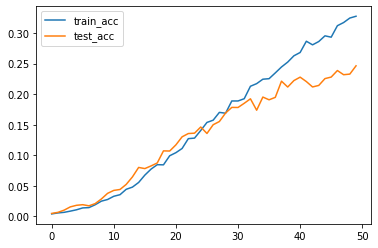

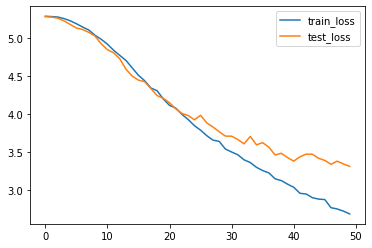

In [43]:
history = model.fit(X_Train, y_train, validation_data=(X_Test, y_test), epochs=epochs, batch_size=384)#64 #32 ---> 64 ~30%
# Final evaluation of the model
scores = model.evaluate(X_Test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

print("done")

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.legend()
plt.show()

## These are the values for 35 epochs

In [390]:

history = model.fit(X_Train, y_train, validation_data=(X_Test, y_test), epochs=epochs, batch_size=32)#64 #32 ---> 64 ~30%
# Final evaluation of the model
scores = model.evaluate(X_Test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

print("done")

Epoch 1/35
255/255 [==============================] - 11s 39ms/step - loss: 5.3036 - accuracy: 0.0033 - val_loss: 5.2883 - val_accuracy: 0.0050
Epoch 2/35
255/255 [==============================] - 10s 37ms/step - loss: 5.2999 - accuracy: 0.0050 - val_loss: 5.2510 - val_accuracy: 0.0095
Epoch 3/35
255/255 [==============================] - 9s 36ms/step - loss: 5.2674 - accuracy: 0.0113 - val_loss: 5.1394 - val_accuracy: 0.0183
Epoch 4/35
255/255 [==============================] - 9s 36ms/step - loss: 5.1797 - accuracy: 0.0119 - val_loss: 5.0735 - val_accuracy: 0.0238
Epoch 5/35
255/255 [==============================] - 9s 36ms/step - loss: 5.1050 - accuracy: 0.0200 - val_loss: 4.8792 - val_accuracy: 0.0387
Epoch 6/35
255/255 [==============================] - 9s 36ms/step - loss: 4.9757 - accuracy: 0.0254 - val_loss: 4.8259 - val_accuracy: 0.0397
Epoch 7/35
255/255 [==============================] - 9s 36ms/step - loss: 4.8609 - accuracy: 0.0390 - val_loss: 4.6190 - val_accuracy: 0.06

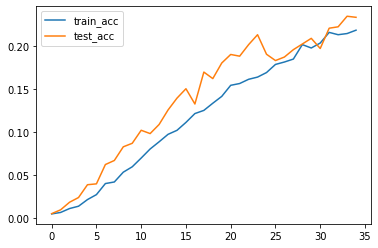

In [393]:

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.legend()
plt.show()

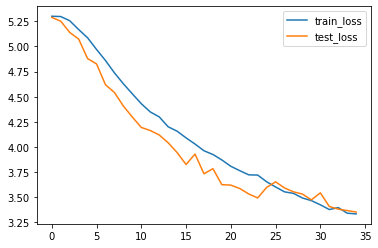

In [394]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.legend()
plt.show()

## These are the 50 epochs

In [396]:
history = model.fit(X_Train, y_train, validation_data=(X_Test, y_test), epochs=epochs, batch_size=32)#64 #32 ---> 64 ~30%
# Final evaluation of the model
scores = model.evaluate(X_Test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

print("done")

Epoch 1/50
255/255 [==============================] - 10s 38ms/step - loss: 5.2997 - accuracy: 0.0062 - val_loss: 5.2715 - val_accuracy: 0.0071
Epoch 2/50
255/255 [==============================] - 9s 37ms/step - loss: 5.2976 - accuracy: 0.0035 - val_loss: 5.2545 - val_accuracy: 0.0076
Epoch 3/50
255/255 [==============================] - 9s 36ms/step - loss: 5.2632 - accuracy: 0.0082 - val_loss: 5.1703 - val_accuracy: 0.0128
Epoch 4/50
255/255 [==============================] - 10s 38ms/step - loss: 5.1726 - accuracy: 0.0141 - val_loss: 5.0307 - val_accuracy: 0.0261
Epoch 5/50
255/255 [==============================] - 10s 38ms/step - loss: 5.0759 - accuracy: 0.0208 - val_loss: 4.9219 - val_accuracy: 0.0343
Epoch 6/50
255/255 [==============================] - 10s 38ms/step - loss: 4.9473 - accuracy: 0.0282 - val_loss: 4.7418 - val_accuracy: 0.0557
Epoch 7/50
255/255 [==============================] - 10s 38ms/step - loss: 4.8270 - accuracy: 0.0422 - val_loss: 4.6099 - val_accuracy: 0

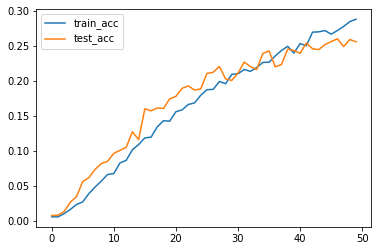

In [397]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.legend()
plt.show()

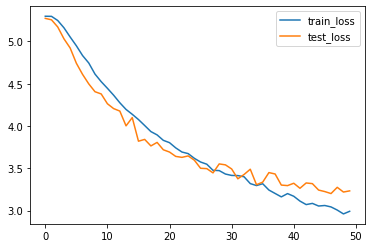

In [398]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.legend()
plt.show()

## These are needed if you have not croped the images into a folder

In [ ]:
def bounding_box(i):
    #for o in mat_train_annos:
    xmin = mat_train_annos[i][0][0][0] # xmin
    ymin = mat_train_annos[i][1][0][0] # ymin
    xmax = mat_train_annos[i][2][0][0] # xmax
    ymax = mat_train_annos[i][3][0][0] # ymax
    return (xmin,ymin,xmax,ymax)

In [ ]:
#croped_training_data = []

for i,image in enumerate(os.listdir("D:/car_devkit/cars_train")):
    bbox=bounding_box(i)
    im=Image.open(os.path.join("D:/car_devkit/cars_train",image))
    im=im.crop(bbox)
    im.save("D:/car_devkit/croped_train/"+ image, 'JPEG')
    #croped_training_data.append([im, image])  
    

In [6]:
def bounding_box_test(i):
    #for o in mat_train_annos:
    xmin = mat_test_annos[i][0][0][0] # xmin
    ymin = mat_test_annos[i][1][0][0] # ymin
    xmax = mat_test_annos[i][2][0][0] # xmax
    ymax = mat_test_annos[i][3][0][0] # ymax
    return (xmin,ymin,xmax,ymax)

In [8]:
#croped_test_data = []

for i,image in enumerate(os.listdir("D:/car_devkit/cars_test")):
    bbox=bounding_box_test(i)
    im=Image.open(os.path.join("D:/car_devkit/cars_test",image))
    im=im.crop(bbox)
    im.save("D:/car_devkit/croped_test/"+ image, 'JPEG')
    #croped_test_data.append([im, image])  
    